In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
import math
import random

if torch.cuda.is_available():
  dev = 'cuda'
  print("Cuda avaiable. Device used to train the model:", dev)
else: 
  dev = 'cpu'
  print("Cuda not avaiable. Device used to train the model:", dev)


Cuda avaiable. Device used to train the model: cuda


# **A harmonic series dataset**

This dataset generates an input signal and an output signal, given a harmonic distribution and a number of cycles we want to compute.

In [5]:
# Second version of HarmonicSeriesDataset
class HarmonicSeriesDataset(Dataset):
    
    def __init__(self, harmonics, amplitudes=[0.25, 0.5, 0.75, 1.0], n_periods=1):
        self.harmonics = torch.tensor(harmonics)
        self.len = n_periods*2*harmonics.size()[0]
        self.amplitudes = amplitudes
        self.sample_rate = 2*harmonics.size()[0]
        self.n_freqs = harmonics.size()[0]
        self.phases = torch.zeros(self.n_freqs)
        self.freqs = torch.linspace(start=0, end=self.n_freqs-1, steps=self.n_freqs)
    
    def __len__(self):
        return 128

    def __getitem__(self, idx):
      
      amp = np.random.choice(self.amplitudes)
      d_1 = np.random.randint(0,self.len/2)
      d_2 = np.random.randint(self.len/2,self.len-2)
      check = np.random.choice([True,False])
      on_off = torch.ones(self.len) if(check) else torch.zeros(self.len)
      on_off[d_1:d_2] = 0 if(check) else 1
      
      input = torch.ones(self.len)*amp if(check) else torch.zeros(self.len)
      input[d_1:d_2] = 0 if(check) else amp
      output = torch.zeros(self.len)
      self.phases[:] = 0
      
      for i in range(self.len):   
        self.phases += (2*np.pi*self.freqs/self.sample_rate)
        self.phases = self.phases * on_off[i]
        output[i] = torch.sum(self.harmonics*torch.sin(self.phases))*input[i]    
      return input, output

# Dataset
Let's generate a dataset and plot its content.

/tmp/ipykernel_10256/2633884264.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.harmonics = torch.tensor(harmonics)


240
4
Samples.shape: torch.Size([32, 240, 2])


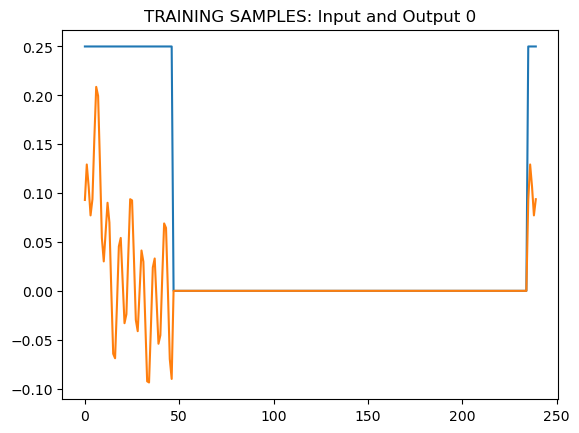

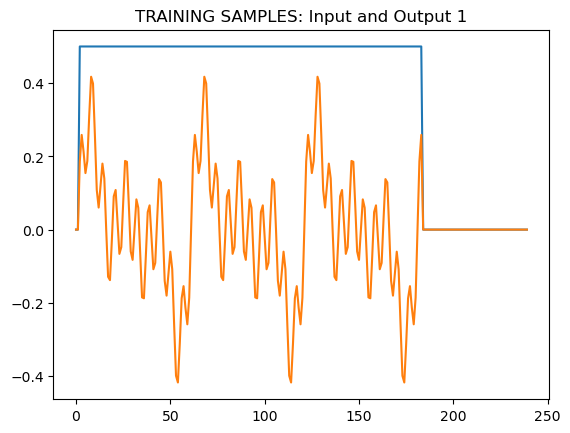

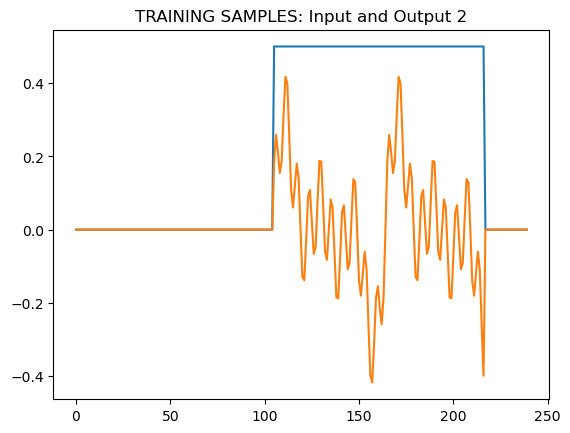

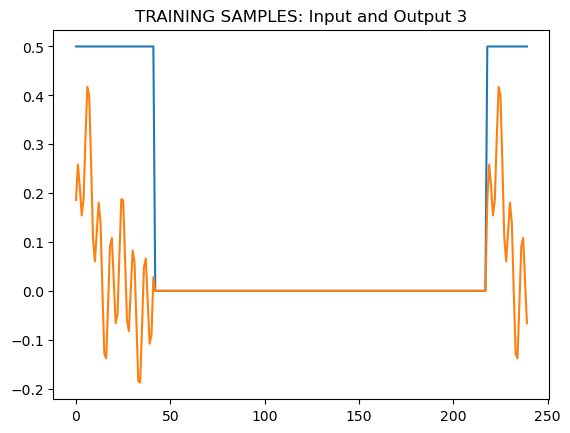

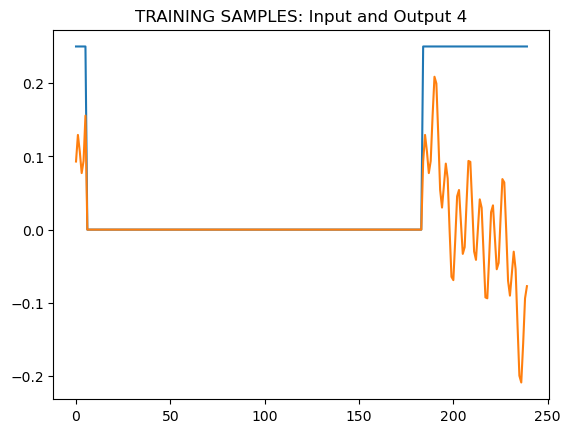

In [6]:
# Dataset configuration
period_len = 60
n_periods = 4
# Generate a distribution of harmonics
harmonics = torch.zeros(period_len//2)
harmonics[1] = 1
harmonics[2] = 1
harmonics[3] = 1
harmonics[10] = 1
# Normalize distribution
harmonics = harmonics/torch.sum(harmonics)

# Create dataset
batch_size = 32
train_dataset = HarmonicSeriesDataset(harmonics=harmonics, n_periods=n_periods)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

# Sample storage to plot
signal_len = len(train_dataloader)
print(period_len*n_periods)
print(signal_len)

# Examples of dataset
train_samples = torch.zeros(batch_size,period_len*n_periods,2)

train_samples[:,:,0], train_samples[:,:,1] = next(iter(train_dataloader))

print("Samples.shape:", train_samples.shape)
for i in range(5):
  plt.plot(train_samples[i,:,0].detach().cpu().numpy())
  plt.plot(train_samples[i,:,1].detach().cpu().numpy())
  plt.title("TRAINING SAMPLES: Input and Output {}".format(i))
  plt.show()



# **Gated Recurrent Unit (GRU)**

In [8]:
class GRUmodel(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, num_layers=1):
    super(GRUmodel, self).__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    # GRU (input)
    self.gru = nn.GRU(input_size, hidden_dim, num_layers=num_layers, batch_first=True)
    # Fully connected (output)
    self.lin = nn.Linear(hidden_dim, output_size)
    
  # Forward method
  def forward(self, seq):

    input = seq  # input.shape = (batch_size, sequence_length ,input_size)
  
    out, hidden = self.gru(input) # out.shape = (sequence_length, hidden_dim) # hidden.shape = (num_layers, hidden_dim)
    out = self.lin(out) # out.shape = (sequence_length,1)
    return out


In [9]:
def gru_evaluate_on_data(net, eval_input, target, device, plot=False):

  L = target.shape[1] # sequence length
  batch_size = target.shape[0] # batch size
  random = np.random.randint(0,batch_size-2)
  target = target[random,:,:].unsqueeze(0).to(device) # ([N,L,1])
  # seq = torch.ones([batch_size,L,1]).to(device) # ([N,L,1])
  seq = eval_input[random,:,:].unsqueeze(0).to(device)

  with torch.no_grad():
    pred = net(seq)
      # Calculate evaluation loss
  eval_loss = torch.sum(torch.abs(target-pred))

  # Plotting results
  if(plot):
    fig, ax = plt.subplots()
    print("[TEST ON DATA] Eval loss {}".format(eval_loss))
    ax.plot(seq[0,:,:].detach().cpu().numpy())
    ax.plot(target[0,:,:].detach().cpu().numpy())
    ax.plot(pred[0,:,:].detach().cpu().numpy())
    plt.show()

  return eval_loss
  
def gru_train(net, epochs, train_dataloader, device, save_state='best_gru.pt'):
  
  net.train()

  # Define Loss, Optimizer, ecc.
  criterion = nn.L1Loss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  best_eval_loss = np.inf

  # target = train_samples[:,:,1].unsqueeze(2).to(device) #([N,L,1])
  # train = train_samples[:,:,1].unsqueeze(2).to(device) #([N,L,1]) 
  # L = target.shape[1] # sequence length
  # n_batches = target.shape[0] # batch size
  epochs_loss = np.zeros(epochs)

  for epoch in range(epochs): 
    optimizer.zero_grad()
    running_loss = 0.0

    for i,sample in enumerate(train_dataloader):
      seq,target = sample
      target = target.unsqueeze(2).to(device)
      seq = seq.unsqueeze(2).to(device)
      prediction = net(seq)
      loss = criterion(prediction, target) # Calculate loss
      loss.backward() # Backpropagation and calculates gradients
      optimizer.step() # Updates the weights
    # Print statistics
    running_loss += loss.item() # To calculate epochs' mean loss
    plot = True if (epoch%(epochs/16)==0) else False
    eval_loss = gru_evaluate_on_data(net, seq, target, device, plot=plot)
    
    epochs_loss[epoch] = eval_loss # For plotting loss during epochs

    if eval_loss < best_eval_loss:
      best_eval_loss = eval_loss
      torch.save(net.state_dict(), save_state)

    if (epoch%(epochs/20) == 0):
        print('Epoch: {}/{} .............'.format(epoch, epochs), end=' ')
        print("Train Loss: {:.4f} - Best Eval {:.4f}".format(running_loss, best_eval_loss))
    
    running_loss = 0.0

  print("---------- FINISHED TRAINING ----------")

  # Print Eval Loss
  x_ = np.linspace(0, epochs-1, epochs)
  y_ = epochs_loss
  yhat_ = signal.savgol_filter(y_, 101, 3) # Savitzky-Golay filter for smoothing

  fig, ax = plt.subplots()
  ax.plot(x_, y_)
  ax.plot(x_, yhat_)
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Eval Loss') 
  # ax.grid(True) 
  plt.show()

# **Training GRUnet**

In [10]:
def train_and_test_GRU(hidden_size, n_hidden_layers, train_dataloader, target, epochs, device, save_state='best_gru.pt'):
  #train_len = train_data.size()[2]

  net = GRUmodel(1,1,hidden_size, n_hidden_layers)
  net = net.to(device)

  model_parameters = filter(lambda p: p.requires_grad, net.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  print("[INFO] Number of parameters: {}".format(params))
  
  # TRAINING
  gru_train(net, epochs, train_dataloader, device, save_state)

  # TEST
  net.load_state_dict(torch.load(save_state))  
  net.eval()
  input,target = next(iter(train_dataloader))
  input = input.unsqueeze(2)
  target = target.unsqueeze(2)
  gru_evaluate_on_data(net, input, target, device, plot=True)

  return net

[INFO] Number of parameters: 12929
[TEST ON DATA] Eval loss 45.816993713378906


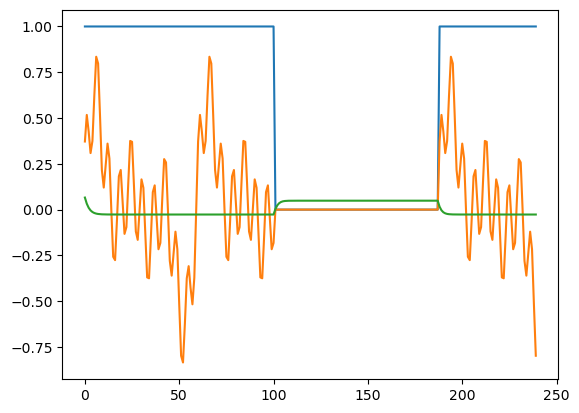

Epoch: 0/5000 ............. Train Loss: 0.1262 - Best Eval 45.8170
Epoch: 250/5000 ............. Train Loss: 0.0790 - Best Eval 1.8268
Epoch: 500/5000 ............. Train Loss: 0.0534 - Best Eval 1.3105
[TEST ON DATA] Eval loss 8.014737129211426


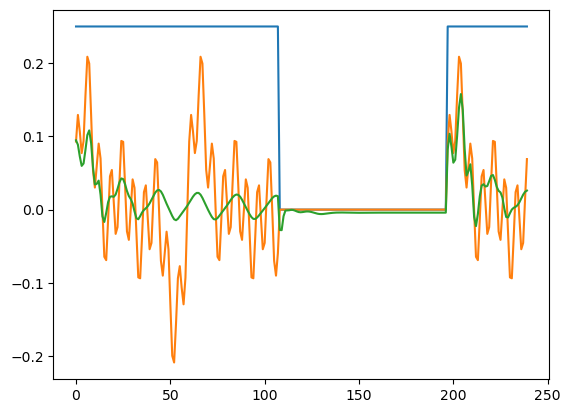

Epoch: 750/5000 ............. Train Loss: 0.0486 - Best Eval 0.8880
Epoch: 1000/5000 ............. Train Loss: 0.0767 - Best Eval 0.5530
[TEST ON DATA] Eval loss 17.41082191467285


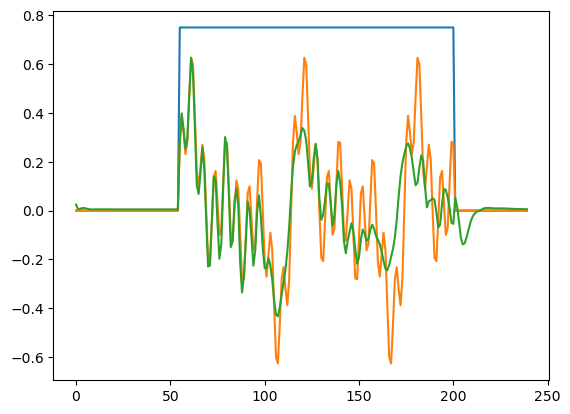

Epoch: 1250/5000 ............. Train Loss: 0.0513 - Best Eval 0.5530
Epoch: 1500/5000 ............. Train Loss: 0.0238 - Best Eval 0.5530
Epoch: 1750/5000 ............. Train Loss: 0.0711 - Best Eval 0.5530
[TEST ON DATA] Eval loss 31.269865036010742


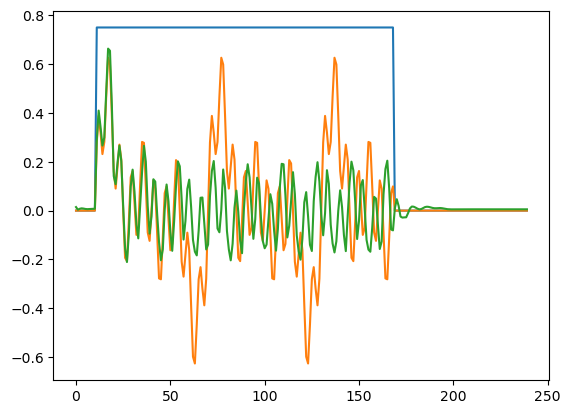

Epoch: 2000/5000 ............. Train Loss: 0.0595 - Best Eval 0.5530
Epoch: 2250/5000 ............. Train Loss: 0.0730 - Best Eval 0.3766
[TEST ON DATA] Eval loss 20.704845428466797


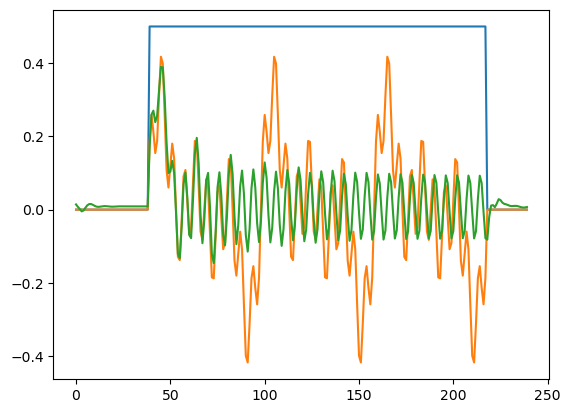

Epoch: 2500/5000 ............. Train Loss: 0.0621 - Best Eval 0.3766
Epoch: 2750/5000 ............. Train Loss: 0.0505 - Best Eval 0.3766
Epoch: 3000/5000 ............. Train Loss: 0.0448 - Best Eval 0.3766
[TEST ON DATA] Eval loss 2.83848237991333


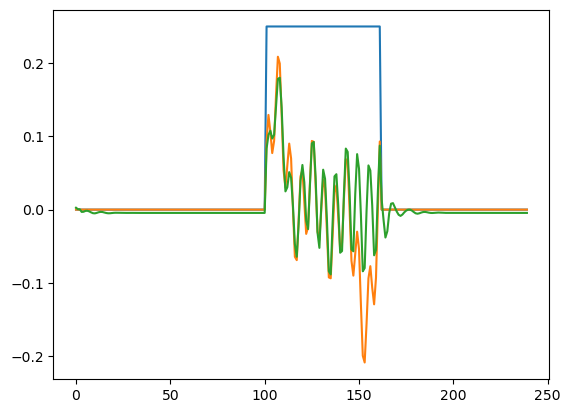

Epoch: 3250/5000 ............. Train Loss: 0.0396 - Best Eval 0.3766
Epoch: 3500/5000 ............. Train Loss: 0.0522 - Best Eval 0.3766
[TEST ON DATA] Eval loss 4.473311424255371


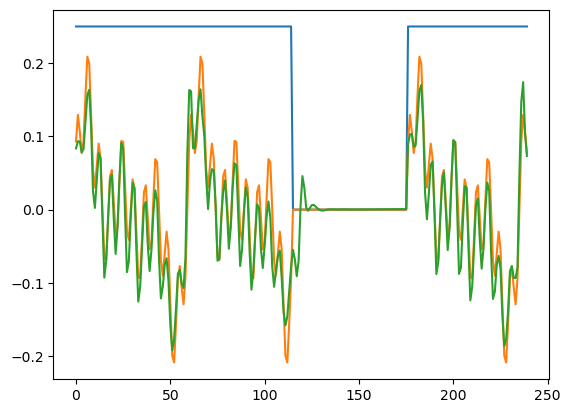

Epoch: 3750/5000 ............. Train Loss: 0.0240 - Best Eval 0.3766
Epoch: 4000/5000 ............. Train Loss: 0.0156 - Best Eval 0.3766
Epoch: 4250/5000 ............. Train Loss: 0.0659 - Best Eval 0.3766
[TEST ON DATA] Eval loss 9.346841812133789


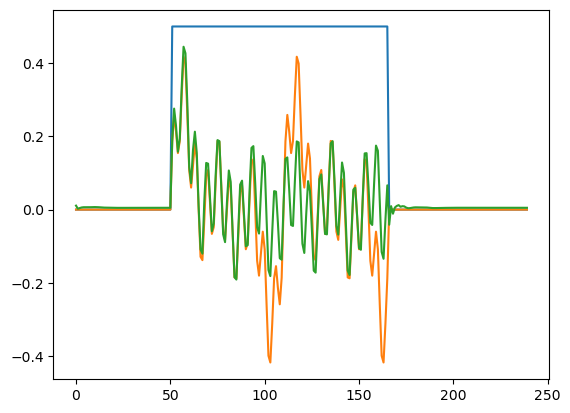

Epoch: 4500/5000 ............. Train Loss: 0.0640 - Best Eval 0.3766
Epoch: 4750/5000 ............. Train Loss: 0.0859 - Best Eval 0.3766
---------- FINISHED TRAINING ----------


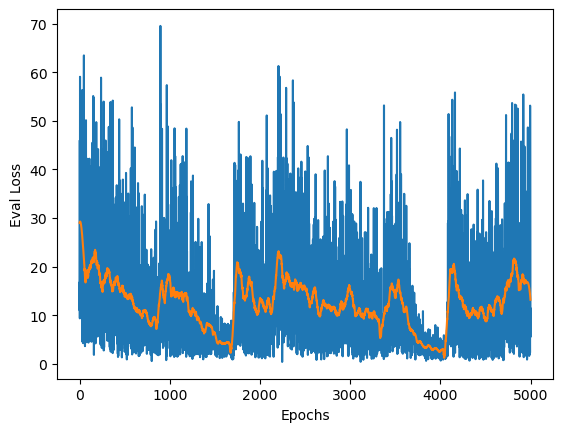

[TEST ON DATA] Eval loss 43.212318420410156


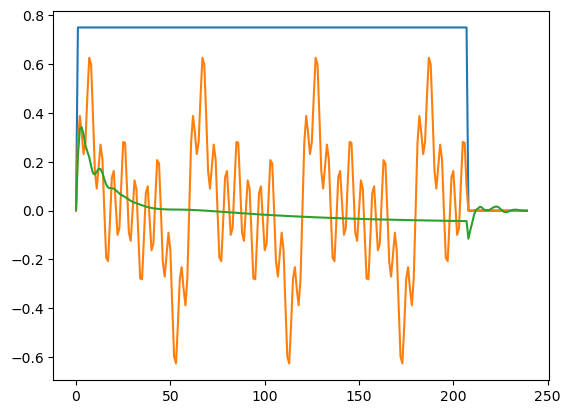

In [11]:
GRUnet = train_and_test_GRU(hidden_size=64, n_hidden_layers=1, train_dataloader=train_dataloader, target=train_dataloader, epochs=5000, device=dev)

# **Testing Trained GRUnet**

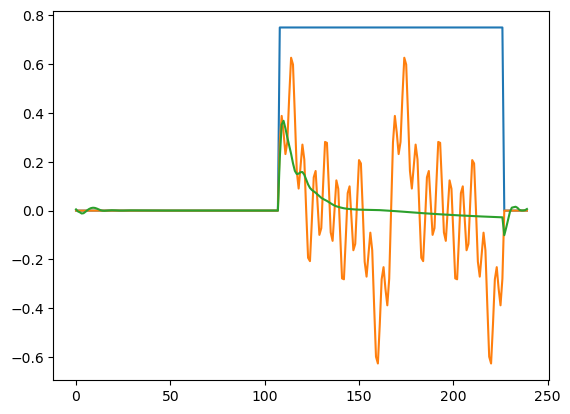

In [12]:
# Testing with a random input+target from dataloader
seq, target = next(iter(train_dataloader))
batch_size = target.shape[0] # batch size
random = np.random.randint(0,batch_size-2)

seq = seq[random,:].unsqueeze(0).unsqueeze(2).to(dev)
target = target[random,:].unsqueeze(0).unsqueeze(2).to(dev)

# Calculate Output
signal = GRUnet(seq)

plt.plot(seq[0,:,:].detach().cpu().numpy())
plt.plot(target[0,:,:].detach().cpu().numpy())
plt.plot(signal[0,:,:].detach().cpu().numpy())
plt.show()

In [ ]:
# Testing with a new dataset with amplitudes different from training dataset
# amplitudes = [float(input("Choose input amplitude for testing dataset: "))]
amplitudes = [0.2, 0.4, 0.6, 0.8]
test_dataset = HarmonicSeriesDataset(harmonics=harmonics, n_periods=n_periods, amplitudes=amplitudes)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

for i in 5:
    seq, target = next(iter(test_dataloader))
    seq = seq[random,:].unsqueeze(0).unsqueeze(2).to(dev)
    target = target[random,:].unsqueeze(0).unsqueeze(2).to(dev)

    # Calculate Output
    signal = GRUnet(seq)

    plt.plot(seq[0,:,:].detach().cpu().numpy())
    plt.plot(target[0,:,:].detach().cpu().numpy())
    plt.plot(signal[0,:,:].detach().cpu().numpy())
    plt.show()